<a href="https://colab.research.google.com/github/Shivanand-1338/Diabetic_prediction_mlops/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run once at the top of the notebook
!pip install -q datasets transformers evaluate scikit-learn matplotlib seaborn
# If you want accelerate for faster HF training
!pip install -q accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [ ]:
# Loads IMDB (train/test split). Each item has 'text' and 'label' (0=neg,1=pos)
dataset = load_dataset("imdb")
print(dataset)
# We'll take a smaller subset for quick iteration (optional)
train_ds = dataset['train']   # 25k
test_ds = dataset['test']     # 25k


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
# Convert to lists
X_train = [x['text'] for x in train_ds]
y_train = [x['label'] for x in train_ds]
X_test  = [x['text'] for x in test_ds]
y_test  = [x['label'] for x in test_ds]

# (Optional) Quick smaller subset for very fast runs
# subset = 5000
# X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=subset, random_state=RANDOM_SEED)


In [ ]:
tfidf = TfidfVectorizer(
    max_features=30000,   # adjust based on memory; 30k is reasonable
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (25000, 30000) (25000, 30000)


In [ ]:
model = LogisticRegression(max_iter=1000, n_jobs=-1)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, n_jobs=-1)

Accuracy: 0.88288
              precision    recall  f1-score   support

           0     0.8840    0.8814    0.8827     12500
           1     0.8817    0.8844    0.8831     12500

    accuracy                         0.8829     25000
   macro avg     0.8829    0.8829    0.8829     25000
weighted avg     0.8829    0.8829    0.8829     25000



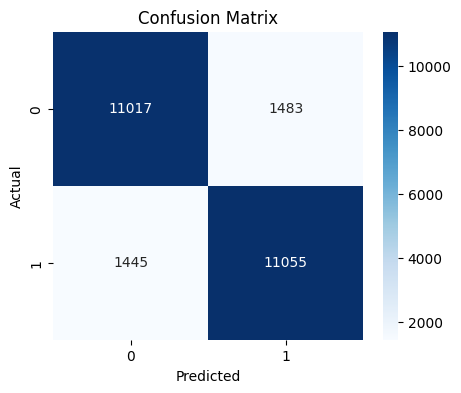

In [ ]:
preds = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, preds))
print(classification_report(y_test, preds, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pickle
os.makedirs("models", exist_ok=True)
with open("models/tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("models/logreg.pkl", "wb") as f:
    pickle.dump(model, f)
print("Saved tfidf and logistic model to /content/models/")

Saved tfidf and logistic model to /content/models/


In [ ]:
import pickle

# Load saved objects
with open("models/tfidf.pkl", "rb") as f:
    tfidf_loaded = pickle.load(f)

with open("models/logreg.pkl", "rb") as f:
    model_loaded = pickle.load(f)

def predict_sentiment_saved(text):
    X = tfidf_loaded.transform([text])
    pred = model_loaded.predict(X)[0]
    prob = model_loaded.predict_proba(X)[0][1]
    sentiment = "POSITIVE" if pred == 1 else "NEGATIVE"
    return sentiment, prob

# Example predictions
print(predict_sentiment_saved("I watched worst movie, great acting!"))
print(predict_sentiment_saved("I loved the movie, great acting!."))


('NEGATIVE', np.float64(0.15763677403511617))
('POSITIVE', np.float64(0.9806043663239377))
